In [1]:
import os
import ExtractMsg
import re

docs=[]
docsQuote=[]
docsQuoteSubject=[]
docsNoQuoteSubject=[]
testDocSubject=[]
docsNoQuote =[]
testDoc =[]
sendTimeQuote = []
sendTimeTest = []
sendTimeNoQuote = []
attachmentsQuote = []
attachmentsNoQuote=[]
attachmentsTest=[]
pathQuote = 'C:/Users/StefanLap/Desktop/Bachelorarbeit/TrainQuote/'
pathNoQuote = 'C:/Users/StefanLap/Desktop/Bachelorarbeit/TrainNoQuote/'
pathTest = 'C:/Users/StefanLap/Desktop/Bachelorarbeit/TestPredict/'

def flag_attachment(mail):
    if  not mail.attachments:
        return 0
    else :
        return 1    


def filldoclist(filepath, fillList, subjectList, timelist, attachmentlist) :
        for file in os.listdir(filepath):
            mail = ExtractMsg.Message(filepath+file)
            try:
                content = mail.body
                contentLinkless = re.sub('<.*?>', '', content)
                fillList.append(contentLinkless)
                subjectList.append(file)
                timelist.append(mail.date)
                attachmentlist.append(flag_attachment(mail))
                continue
            except UnicodeDecodeError:
                continue                
            
            
filldoclist(pathQuote, docsQuote, docsQuoteSubject, sendTimeQuote, attachmentsQuote)
filldoclist(pathNoQuote, docsNoQuote, docsNoQuoteSubject, sendTimeNoQuote, attachmentsNoQuote)
filldoclist(pathTest, testDoc, testDocSubject, sendTimeTest, attachmentsTest)

        
docs = docsQuote + docsNoQuote
trainSubjects = docsQuoteSubject + docsNoQuoteSubject
trainSendTime = sendTimeQuote + sendTimeNoQuote
trainAttachments = attachmentsQuote + attachmentsNoQuote




    

In [2]:
import numpy as np
import nltk
#Zählt wie viele ? im Text auftreten
def count_question(content):
    my_list = []
    for text in content:
        count = 0
        tokens = nltk.word_tokenize(text)
        for word in tokens:
            if(word == "?"):
                count = count + 1
            else:
                continue
        my_list.append(count)
    x = np.asmatrix(my_list)
    return x.transpose()




In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction import text
from dateutil.parser import parse

import numpy as np
import pandas as pd
from scipy.sparse import hstack


targetlist=[]

for i in range(0,len(docsQuote)):
    targetlist.append(1)

for i in range(0,len(docsNoQuote)):
    targetlist.append(0)

# Labels werden in array umgewandelt dass classifier es benutzen können shape = traindoclänge x 1
train_y = np.asarray(targetlist)

# Uhrzeit wird in 3 int Werte umgewandelt und einzeln abgespeichert shape = doclänge x 3
def parse_send_time(timelist):
    n = len(timelist)
    m = 3
    parsed_list = [[0] * m for i in range(n)]
    for i in range(n):
        time =  timelist[i]
        if(time != None):
            dt = parse(time)            
            parsed_list[i][0] =dt.strftime('%H')
            parsed_list[i][1]=dt.strftime('%M')
            parsed_list[i][2]=dt.strftime('%S')
            
        else :
            parsed_list[i][0] = 0
            parsed_list[i][1]= 0
            parsed_list[i][2]= 0
    return np.asarray(parsed_list)




#training und test content im Block da Tfidftransformer bei beiden gebraucht werden

file =open('C:/Users/StefanLap/Desktop/Bachelorarbeit/stopwords.txt', 'r', encoding='utf8')
stop_words_ger = file.read()

my_stop_words = frozenset(nltk.word_tokenize(stop_words_ger))


count_vect = CountVectorizer(stop_words=my_stop_words )
content_count = count_vect.fit_transform(docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(content_count)
content_tfidf = tf_transformer.transform(content_count).toarray()


test_content_counts = count_vect.transform(testDoc)
test_content_tfidf = tf_transformer.transform(test_content_counts).toarray()


#training und test subject im Block da Tfidftransformer bei beiden gebraucht wird

count_vect_subject = CountVectorizer( )
subject_count = count_vect_subject.fit_transform(trainSubjects)
tf_subject_transformer =TfidfTransformer(use_idf=False).fit(subject_count)
subject_tfidf = tf_subject_transformer.transform(subject_count).toarray()

test_subject_counts = count_vect_subject.transform(testDocSubject)
test_subject_tfidf = tf_subject_transformer.transform(test_subject_counts).toarray()

#verusch tfidf des Inhalts und Countvectorizer des Betreffs zu kombinieren




#print(content_tfidf.shape)
#print(test_content_tfidf.shape)
#print(subject_tfidf.shape)
#print(test_subject_tfidf.shape)



train_attachments = np.asarray([trainAttachments]).transpose()
train_send_time = parse_send_time(trainSendTime)
numpyTarget = np.asarray([targetlist])
train_count_question = count_question(docs)



test_attachments = np.asarray([attachmentsTest])
test_send_time = parse_send_time(sendTimeTest)
test_count_question = count_question(testDoc)



test_content_subject_set = np.hstack((test_content_tfidf, test_subject_tfidf))
test_content_subject_time_set = np.hstack((test_content_tfidf, test_subject_tfidf, test_send_time))
test_content_subject_time_attachments_set = np.concatenate((test_content_subject_time_set, test_attachments.T ), axis=1)
test_content_subject_time_attachments_question_set = np.hstack((test_content_subject_time_attachments_set, test_count_question))
#test_content_subject_attachment_set = np.hstack((test_content_subject_set, train_attachments))
      




train_content_subject_set = np.hstack((content_tfidf, subject_tfidf))
train_content_subject_attachment_set = np.hstack((train_content_subject_set, train_attachments))
train_content_subject_time_set = np.hstack((content_tfidf, subject_tfidf, train_send_time))
train_content_subject_label_set =np.concatenate((train_content_subject_set, numpyTarget.T), axis=1)
train_content_subject_time_attachments_set = np.hstack((train_content_subject_time_set, train_attachments ))
train_content_subject_time_attachments_question_set = np.hstack((train_content_subject_time_attachments_set, train_count_question))

x_test =  np.array(test_content_subject_set).astype(np.float) 
x_train = np.array(train_content_subject_time_attachments_set).astype(np.float)






In [8]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

def fit_neuronal(training_dataset, targetlist):
    temp_neuronal = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
    temp_neuronal.fit(training_dataset, targetlist)
    return temp_neuronal

def fit_svm(training_dataset, targetlist):
    scaler = StandardScaler()
    X = scaler.fit_transform(training_dataset)
    temp_svm = LinearSVC()
    temp_svm.fit(X, targetlist)
    return temp_svm


def fit_knn(training_dataset, targetlist):
    temp_knn= KNeighborsClassifier(n_neighbors=7)
    temp_knn.fit(training_dataset, targetlist)
    return temp_knn

def fit_NB(training_dataset, targetlist, bernoulli):
    if (bernoulli == True) :
        temp_NB = BernoulliNB()
        temp_NB.fit(training_dataset, targetlist)
        return temp_NB
    else :
        temp_NB = GaussianNB()
        temp_NB.fit(training_dataset, targetlist)
        return temp_NB
    
#nb = fit_NB(x_train, targetlist, False)
#nb_B = fit_NB(x_train, targetlist, True)
#knn = fit_knn(x_train, targetlist)
#svm = fit_svm(x_train, targetlist)

#neuronal = fit_neuronal(x_train, targetlist)






In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

#Precision Recall wert
X = x_train
y = numpyTarget.transpose()
random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=random_state)




classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train.ravel())
#y_score = classifier.decision_function(X_test)
#y_score = classifier.score(X_test,)



#average_precision = average_precision_score(y_test, y_score)

#print('Average precision-recall score: {0:0.2f}'.format(
      #average_precision))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [43]:
# Recall value des Classiifers
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def predicter(classi, to_check):
    value = classi.predict(to_check)
    return value

y_true = y_test
y_pred = predicter(classifier, X_test)

print(precision_score(y_true, y_pred, average="weighted"))
print(precision_score(y_true, y_pred, average="micro"))
print(precision_score(y_true, y_pred, average="macro"))

print("------------------------------")

print(metrics.recall_score(y_true, y_pred, average='weighted'))
print(recall_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='micro'))


0.647320261438
0.613333333333
0.640522875817
------------------------------
0.613333333333
0.626945786366
0.613333333333


In [21]:
from sklearn import metrics
confusion =metrics.confusion_matrix(y_true, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print("Accuracy")
print(  (TP + TN) / float(TP + TN + FP + FN))
print("recall/Sensitivity")
print(TP / float(TP + FN))
print("Speceificity -> if value = negative wie oft korrekt")
print(TN / float(TN + FP))
print("Precision")
print(TP / float(TP + FP))



Accuracy
0.76
recall/Sensitivity
0.811594202899
Speceificity -> if value = negative wie oft korrekt
0.716049382716
Precision
0.708860759494


In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
ss = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)


In [54]:
scoring = 'accuracy'
score= cross_val_score(classifier, x_train, targetlist, cv=k_fold, n_jobs=1, scoring=scoring)

print(round(np.mean(score)*100, 2))


[ 0.7         0.63333333  0.66666667  0.53333333  0.56666667  0.66666667
  0.56666667  0.66666667  0.7         0.46666667]


In [42]:

predicted_nb = classifier.predict(x_test)




GaussianNB
[1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0]
KNN
BernoulliNB
SVM
neuronal


In [20]:
from sklearn.model_selection import GridSearchCV

scores = ['precision', 'recall']




tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
clf = GridSearchCV(SVC(),tuned_parameters , cv=5)
                    
clf.fit(train_content_subject_set, targetlist)

print(clf.best_params_)
print(clf.cv_results_['mean_test_score'])
print(clf.cv_results_['std_test_score'])


{'C': 1, 'kernel': 'linear'}
[ 0.52861953  0.52861953  0.52861953  0.52861953  0.78451178  0.52861953
  0.7979798   0.78451178  0.80808081  0.76430976  0.69360269  0.67676768]
[ 0.00388129  0.00388129  0.00388129  0.00388129  0.03443909  0.00388129
  0.0233637   0.03443909  0.02378005  0.04257719  0.08324153  0.07193639]


In [21]:
from sklearn.model_selection import GridSearchCV


gs = GridSearchCV(MLPClassifier(), param_grid={
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(30,40,50,60)], #[x for x in itertools.product((10,20,30,40,50,100),repeat=3)]

'activation': ["logistic", "relu", "tanh"]})
gs.fit(x_train, targetlist)



GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(30, 40, 50, 60)], 'activation': ['logistic', 'relu', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
x=gs.predict(x_test)
print(x)

[1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1]


In [36]:
k_range = list(range(1,31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores= cross_val_score(knn, x_train, targetlist, cv=10, scoring=scoring)
    k_scores.append(scores.mean())
print(k_scores)    

[0.60333333333333328, 0.59999999999999998, 0.59000000000000008, 0.59942528735632183, 0.59724137931034482, 0.60356321839080462, 0.59344827586206894, 0.61045977011494268, 0.58666666666666667, 0.60011494252873554, 0.58609195402298853, 0.57310344827586202, 0.56287356321839077, 0.57310344827586202, 0.54287356321839075, 0.55977011494252871, 0.55229885057471262, 0.5798850574712644, 0.55597701149425283, 0.5832183908045977, 0.55287356321839076, 0.55931034482758624, 0.55574712643678159, 0.57620689655172419, 0.5627586206896551, 0.58632183908045976, 0.55954022988505736, 0.56643678160919531, 0.5594252873563218, 0.55252873563218396]


Text(0,0.5,'Cross-Validated Accuracy')

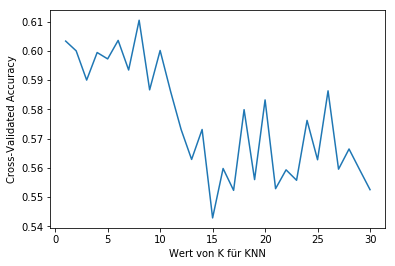

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_range, k_scores)
plt.xlabel('Wert von K für KNN')
plt.ylabel('Cross-Validated Accuracy')

In [23]:
#Plotten des Precision recall wertes
from sklearn.metrics import precision_recall_curve
from __future__ import print_function
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

NameError: name 'y_score' is not defined

In [45]:
classifier.predict(X_test)[0:10]


array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1])

In [46]:
classifier.predict_proba(X_test)

array([[ 0.57142857,  0.42857143],
       [ 0.28571429,  0.71428571],
       [ 0.28571429,  0.71428571],
       [ 0.42857143,  0.57142857],
       [ 0.42857143,  0.57142857],
       [ 0.71428571,  0.28571429],
       [ 0.57142857,  0.42857143],
       [ 0.71428571,  0.28571429],
       [ 0.28571429,  0.71428571],
       [ 0.14285714,  0.85714286],
       [ 0.28571429,  0.71428571],
       [ 0.42857143,  0.57142857],
       [ 0.28571429,  0.71428571],
       [ 0.14285714,  0.85714286],
       [ 0.42857143,  0.57142857],
       [ 0.42857143,  0.57142857],
       [ 0.42857143,  0.57142857],
       [ 0.14285714,  0.85714286],
       [ 0.28571429,  0.71428571],
       [ 0.85714286,  0.14285714],
       [ 0.42857143,  0.57142857],
       [ 0.42857143,  0.57142857],
       [ 0.28571429,  0.71428571],
       [ 0.14285714,  0.85714286],
       [ 0.57142857,  0.42857143],
       [ 0.14285714,  0.85714286],
       [ 0.42857143,  0.57142857],
       [ 0.57142857,  0.42857143],
       [ 0.71428571,

In [47]:
y_pred_class = classifier.predict_proba(X_test)[:, 1]

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

Text(0,0.5,'Frequency')

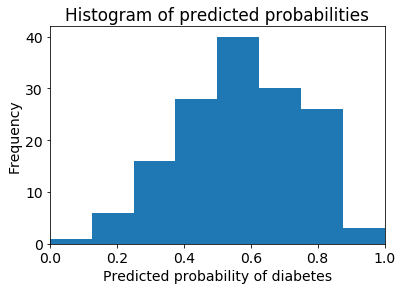

In [49]:
plt.hist(y_pred_class, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

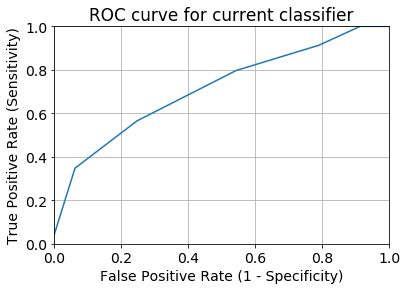

In [51]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for current classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)